<a href="https://colab.research.google.com/github/nirnayroy/2d-billiards/blob/master/Copy_of_2d_billiards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fermi Acceleration in 2d-billiards

# Imports

In [ ]:
!pip install shapely

In [39]:
#@title
import numpy as np
#from scipy import optimize
#from scipy.misc import derivative
import matplotlib.pyplot as plt
#import pickle 
from sklearn.preprocessing import normalize

#from shapely.geometry import LineString
#from shapely.geometry import Point

# Some functions

In [79]:
#slit position
def slit(t, s, omega):
    return -s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


# Travel for rectangle with slit

In [ ]:

#mapping function from one state to the next  
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


In [ ]:

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


In [ ]:

def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


In [ ]:

omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
    dbfile = open('ensemble2_100', 'ab') 
      
    # source, destination 
    pickle.dump(systems, dbfile)                      
    dbfile.close()
    return systems



In [ ]:

systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)


In [ ]:
import matplotlib.pyplot as plt
def load_and_plot(time_step=1):
    
    dbfile = open('ensemble2', 'rb')      
    systems = pickle.load(dbfile) 
    
    t = 1
    
    tfs = []
    for i in systems:
        last_state = i[len(i)-1]
        #print(last_state)
        (x, y, u, v, tm) = last_state
        tfs.append(tm)
    
    tf = min(tfs)
     
    #print(tf)
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<t2 and t>t1:
                    v += ((v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        #print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

[4333.7531107363575, 4620.855276032316, 5166.599944930533, 5699.88178690181, 6123.237379250558, 6342.2125597567365, 6350.904854983463, 6856.617443316063, 7486.465641915043, 8012.077270917688, 8486.73231278515, 8652.635143721285, 9491.019845687464, 9577.259902409387, 10287.677709275411, 10466.46170717086, 11347.304446746577, 12545.698230169282, 14024.503667592347, 14909.898383584286, 17242.622126118804, 18677.013810298922, 20508.175033088428, 23931.24883240195, 21108.74190138676, 21780.135594746956, 23576.32517277359, 23678.46022377276, 26002.784754953438, 27028.108758986356, 30821.53984096212, 30936.95811236209, 29092.146627217953, 31125.56130226421, 30880.65087704504, 31982.442207685974]
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501]


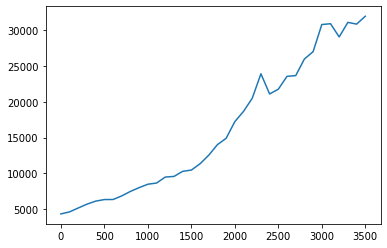

In [ ]:
load_and_plot(time_step=100)

In [ ]:
import pickle 
dbfile = open('ensemble2_100', 'rb')      
systems = pickle.load(dbfile) 

FileNotFoundError: [Errno 2] No such file or directory: 'ensemble2_100'

# Stadium Billiards

next wall: semi-circle enclosure
entered enclosure: x: -0.6597560975609755 y: 1 u: 0.16056719385235946 v: 6.583254947946738
unnormalized collision
exit enclosure: x: [1.85335822] y: 1 u: [-0.16056719] v: [-6.58325495]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.75339435] y: 1 u: [-0.16056719] v: [6.58548064]
exit enclosure: x: [-0.35938565] y: 1 u: [-5.93527778] v: [-2.85776395]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-0.86054951] y: 1 u: [-5.93527778] v: [2.86240238]
exit enclosure: x: [-1.52309921] y: 1 u: [4.08933529] v: [-5.16703074]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.713891] y: 1 u: [4.08933529] v: [5.17373222]
exit enclosure: x: [1.61857291] y: 1 u: [-4.84144478] v: [-4.47778747]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.20140257] y: 1 u: [4.84144478] v: [4.48591425]
unnormalized collision
exit enclosure: x: [-1.0094214

exit enclosure: x: [0.87784274] y: 1 u: [-4.67652732] v: [-4.67976712]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80091574] y: 1 u: [4.67652732] v: [4.66777651]
exit enclosure: x: [-0.79652868] y: 1 u: [-4.67069526] v: [-4.6736122]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88168442] y: 1 u: [4.67069526] v: [4.66367072]
exit enclosure: x: [0.88349546] y: 1 u: [-4.66601341] v: [-4.66835492]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79294405] y: 1 u: [4.66601341] v: [4.6601426]
unnormalized collision
exit enclosure: x: [-0.78999979] y: 1 u: [-4.66210036] v: [-4.66405729]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88548809] y: 1 u: [4.66210036] v: [4.65823148]
exit enclosure: x: [0.88648447] y: 1 u: [-4.65952146] v: [-4.66081109]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.788246

exit enclosure: x: [-0.81296644] y: 1 u: [-4.68938858] v: [-4.68585566]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86114611] y: 1 u: [4.68938858] v: [4.70120812]
unnormalized collision
exit enclosure: x: [0.85806742] y: 1 u: [-4.69727158] v: [-4.69333173]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81973567] y: 1 u: [4.69727158] v: [4.70962289]
unnormalized collision
exit enclosure: x: [-0.82591014] y: 1 u: [-4.70550939] v: [-4.70139228]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8506463] y: 1 u: [4.70550939] v: [4.71859385]
unnormalized collision
exit enclosure: x: [0.84722436] y: 1 u: [-4.7142364] v: [-4.70987491]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83324877] y: 1 u: [4.7142364] v: [4.72754012]
exit enclosure: x: [-0.83989238] y: 1 u: [-4.72310972] v: [-4.71867514]
next wall: left
bottom bar
next wall: semi-cir

exit enclosure: x: [-0.85786379] y: 1 u: [-4.74678799] v: [-4.74236752]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82556554] y: 1 u: [4.74678799] v: [4.75955479]
exit enclosure: x: [0.8221968] y: 1 u: [-4.755303] v: [-4.7510474]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.86473358] y: 1 u: [4.755303] v: [4.76755575]
unnormalized collision
exit enclosure: x: [-0.87083716] y: 1 u: [-4.763475] v: [-4.75939075]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81603241] y: 1 u: [4.763475] v: [4.77473257]
exit enclosure: x: [0.81305259] y: 1 u: [-4.770983] v: [-4.76723048]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87677629] y: 1 u: [4.770983] v: [4.78144813]
exit enclosure: x: [-0.88198511] y: 1 u: [-4.7779623] v: [-4.77447393]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80815954] y: 1 u: [

entered enclosure: x: [-0.8977005] y: 1 u: [4.80017546] v: [4.80096474]
exit enclosure: x: [-0.89809289] y: 1 u: [-4.80070166] v: [-4.80043857]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79890223] y: 1 u: [4.80070166] v: [4.79937663]
exit enclosure: x: [0.7992545] y: 1 u: [-4.79981835] v: [-4.80026002]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89697282] y: 1 u: [4.79981835] v: [4.79722625]
exit enclosure: x: [-0.8956838] y: 1 u: [-4.79809044] v: [-4.79895447]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80198489] y: 1 u: [4.79809044] v: [4.79344986]
unnormalized collision
exit enclosure: x: [0.80321688] y: 1 u: [-4.79499722] v: [-4.79654408]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89275881] y: 1 u: [4.79499722] v: [4.78918564]
exit enclosure: x: [-0.88986715] y: 1 u: [-4.79112362] v: [-4.79306081]
next wall: left
bot

exit enclosure: x: [0.87968163] y: 1 u: [-4.67357493] v: [-4.67640986]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7955715] y: 1 u: [4.67357493] v: [4.66613564]
unnormalized collision
exit enclosure: x: [-0.79184411] y: 1 u: [-4.66861672] v: [-4.67109648]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88266649] y: 1 u: [4.66861672] v: [4.663049]
exit enclosure: x: [0.88410146] y: 1 u: [-4.66490565] v: [-4.66676155]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78911087] y: 1 u: [4.66490565] v: [4.66055376]
exit enclosure: x: [-0.78692988] y: 1 u: [-4.66200484] v: [-4.66345547]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88516141] y: 1 u: [4.66200484] v: [4.65973895]
unnormalized collision
exit enclosure: x: [0.88574508] y: 1 u: [-4.66049437] v: [-4.66124966]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered en

entered enclosure: x: [0.84182528] y: 1 u: [4.74051456] v: [4.72703199]
exit enclosure: x: [0.84535077] y: 1 u: [-4.73153044] v: [-4.73602464]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84023932] y: 1 u: [4.73153044] v: [4.7180742]
exit enclosure: x: [-0.8335164] y: 1 u: [-4.72256387] v: [-4.72704929]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85287938] y: 1 u: [4.72256387] v: [4.70931686]
exit enclosure: x: [0.85632922] y: 1 u: [-4.71373666] v: [-4.71815234]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8261642] y: 1 u: [4.71373666] v: [4.70084109]
exit enclosure: x: [-0.81971525] y: 1 u: [-4.70514354] v: [-4.70944206]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86320204] y: 1 u: [4.70514354] v: [4.69299115]
exit enclosure: x: [0.86635494] y: 1 u: [-4.69704544] v: [-4.70109623]
bottom bar
next wall: left
next wall: semi-c

exit enclosure: x: [-0.79042465] y: 1 u: [-4.66668442] v: [-4.66522905]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87822544] y: 1 u: [4.66668442] v: [4.67304594]
exit enclosure: x: [0.87658055] y: 1 u: [-4.6709264] v: [-4.66880589]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79437698] y: 1 u: [4.6709264] v: [4.67837369]
exit enclosure: x: [-0.79810391] y: 1 u: [-4.67589258] v: [-4.67341015]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87119291] y: 1 u: [4.67589258] v: [4.68505893]
unnormalized collision
exit enclosure: x: [0.86881552] y: 1 u: [-4.68200547] v: [-4.67895002]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8035373] y: 1 u: [4.68200547] v: [4.69204594]
exit enclosure: x: [-0.80855795] y: 1 u: [-4.68870151] v: [-4.68535468]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8622544

entered enclosure: x: [0.81706466] y: 1 u: [4.76221756] v: [4.77395852]
exit enclosure: x: [0.81395833] y: 1 u: [-4.77004808] v: [-4.76613443]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87229858] y: 1 u: [4.77004808] v: [4.78106768]
exit enclosure: x: [-0.87777949] y: 1 u: [-4.7773973] v: [-4.7737241]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80869083] y: 1 u: [4.7773973] v: [4.78709774]
exit enclosure: x: [0.80611759] y: 1 u: [-4.78386645] v: [-4.78063297]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88280201] y: 1 u: [4.78386645] v: [4.7926026]
unnormalized collision
exit enclosure: x: [-0.88714427] y: 1 u: [-4.78969232] v: [-4.78678027]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80234566] y: 1 u: [4.78969232] v: [4.79673982]
exit enclosure: x: [0.8004727] y: 1 u: [-4.7943918] v: [-4.79204264]
bottom bar
next wall: le

entered enclosure: x: [0.80645718] y: 1 u: [4.78167988] v: [4.79069318]
exit enclosure: x: [0.80406466] y: 1 u: [-4.78769063] v: [-4.7846862]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8850555] y: 1 u: [4.78769063] v: [4.7956821]
exit enclosure: x: [-0.88902643] y: 1 u: [-4.79301976] v: [-4.79035594]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80075694] y: 1 u: [4.79301976] v: [4.79923785]
unnormalized collision
exit enclosure: x: [0.79910372] y: 1 u: [-4.79716605] v: [-4.79509335]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8920706] y: 1 u: [4.79716605] v: [4.80219975]
unnormalized collision
exit enclosure: x: [-0.89457094] y: 1 u: [-4.80052244] v: [-4.79884454]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79757055] y: 1 u: [4.80052244] v: [4.80355334]
exit enclosure: x: [0.79676414] y: 1 u: [-4.80254325] v: [-4.80153295]

entered enclosure: x: [-0.88706945] y: 1 u: [4.79121469] v: [4.79842886]
exit enclosure: x: [-0.89065314] y: 1 u: [-4.79602534] v: [-4.79362062]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79937491] y: 1 u: [4.79602534] v: [4.80139086]
exit enclosure: x: [0.79794788] y: 1 u: [-4.79960302] v: [-4.79781451]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89322027] y: 1 u: [4.79960302] v: [4.80375202]
unnormalized collision
exit enclosure: x: [-0.89528074] y: 1 u: [-4.80236942] v: [-4.80098642]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79692908] y: 1 u: [4.80236942] v: [4.80447412]
exit enclosure: x: [0.79636905] y: 1 u: [-4.80377265] v: [-4.80307109]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89604124] y: 1 u: [4.80377265] v: [4.80459484]
exit enclosure: x: [-0.89644956] y: 1 u: [-4.8043208] v: [-4.80404673]
next wall: left
b

exit enclosure: x: [-0.83666991] y: 1 u: [-4.73135399] v: [-4.73583809]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84798258] y: 1 u: [4.73135399] v: [4.71793666]
unnormalized collision
exit enclosure: x: [0.85148249] y: 1 u: [-4.72241333] v: [-4.72688578]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82919954] y: 1 u: [4.72241333] v: [4.70924474]
exit enclosure: x: [-0.82262205] y: 1 u: [-4.71363836] v: [-4.71802789]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85861392] y: 1 u: [4.71363836] v: [4.70104481]
exit enclosure: x: [0.86188624] y: 1 u: [-4.7052464] v: [-4.70944425]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81570098] y: 1 u: [4.7052464] v: [4.69321377]
exit enclosure: x: [-0.80968573] y: 1 u: [-4.69722807] v: [-4.70123895]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.868041

entered enclosure: x: [0.88165002] y: 1 u: [4.67069218] v: [4.66588171]
unnormalized collision
exit enclosure: x: [0.88289017] y: 1 u: [-4.66748575] v: [-4.66908924]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78621595] y: 1 u: [4.66748575] v: [4.66391526]
unnormalized collision
exit enclosure: x: [-0.78442875] y: 1 u: [-4.66510573] v: [-4.66629589]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88348152] y: 1 u: [4.66510573] v: [4.66364957]
unnormalized collision
exit enclosure: x: [0.88385682] y: 1 u: [-4.66413501] v: [-4.66462039]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78405623] y: 1 u: [4.66413501] v: [4.66396974]
exit enclosure: x: [-0.78397351] y: 1 u: [-4.66402483] v: [-4.66407992]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88246979] y: 1 u: [4.66402483] v: [4.66601689]
exit enclosure: x: [0.88195594] y: 1 u: [-4

entered enclosure: x: [0.82931239] y: 1 u: [4.74183586] v: [4.75513782]
exit enclosure: x: [0.82580799] y: 1 u: [-4.75070798] v: [-4.74627399]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.85361178] y: 1 u: [4.75070798] v: [4.76368837]
exit enclosure: x: [-0.86006984] y: 1 u: [-4.75936551] v: [-4.75503871]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81904285] y: 1 u: [4.75936551] v: [4.77165936]
exit enclosure: x: [0.81579279] y: 1 u: [-4.76756494] v: [-4.76346698]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.86663055] y: 1 u: [4.76756494] v: [4.77923615]
exit enclosure: x: [-0.87243194] y: 1 u: [-4.77534892] v: [-4.77145851]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81006839] y: 1 u: [4.77534892] v: [4.78585568]
exit enclosure: x: [0.80728277] y: 1 u: [-4.78235599] v: [-4.77885374]
bottom bar
next wall: left
next wall: sem

exit enclosure: x: [0.87337089] y: 1 u: [-4.67683939] v: [-4.67452271]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79409505] y: 1 u: [4.67683939] v: [4.68483892]
exit enclosure: x: [-0.79809283] y: 1 u: [-4.68217393] v: [-4.67950742]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86772867] y: 1 u: [4.68217393] v: [4.69182271]
exit enclosure: x: [0.86522328] y: 1 u: [-4.68860866] v: [-4.6853924]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80377076] y: 1 u: [4.68860866] v: [4.69908333]
exit enclosure: x: [-0.80900118] y: 1 u: [-4.69559437] v: [-4.69210281]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85848919] y: 1 u: [4.69559437] v: [4.70731355]
exit enclosure: x: [0.85543484] y: 1 u: [-4.7034104] v: [-4.69950401]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81571304] y: 1 u: [4.7034104]

exit enclosure: x: [0.79788077] y: 1 u: [-4.79993244] v: [-4.79775041]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8898124] y: 1 u: [4.79993244] v: [4.80530853]
unnormalized collision
exit enclosure: x: [-0.89248005] y: 1 u: [-4.80351717] v: [-4.80172514]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79614627] y: 1 u: [4.80351717] v: [4.80691176]
exit enclosure: x: [0.79524281] y: 1 u: [-4.8057805] v: [-4.80464897]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89395115] y: 1 u: [4.8057805] v: [4.80790872]
exit enclosure: x: [-0.89500707] y: 1 u: [-4.80719941] v: [-4.80649001]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79537546] y: 1 u: [4.80719941] v: [4.80722815]
unnormalized collision
exit enclosure: x: [0.79536782] y: 1 u: [-4.80721857] v: [-4.80720899]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered en

exit enclosure: x: [-0.8268447] y: 1 u: [-4.7237892] v: [-4.72825205]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85299893] y: 1 u: [4.7237892] v: [4.71075822]
exit enclosure: x: [0.8563913] y: 1 u: [-4.71510588] v: [-4.71944954]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81964688] y: 1 u: [4.71510588] v: [4.70251206]
exit enclosure: x: [-0.81335897] y: 1 u: [-4.70671374] v: [-4.71091168]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8629942] y: 1 u: [4.70671374] v: [4.69500098]
unnormalized collision
exit enclosure: x: [0.86603244] y: 1 u: [-4.69890848] v: [-4.70281273]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80698956] y: 1 u: [4.69890848] v: [4.68792596]
unnormalized collision
exit enclosure: x: [-0.80150199] y: 1 u: [-4.69158965] v: [-4.69525049]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enc

exit enclosure: x: [-0.8085542] y: 1 u: [-4.69821339] v: [-4.69469319]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85716841] y: 1 u: [4.69821339] v: [4.70999972]
unnormalized collision
exit enclosure: x: [0.85409537] y: 1 u: [-4.70607423] v: [-4.70214545]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81529569] y: 1 u: [4.70607423] v: [4.71839852]
exit enclosure: x: [-0.82143977] y: 1 u: [-4.714294] v: [-4.7101859]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84669797] y: 1 u: [4.714294] v: [4.72735975]
unnormalized collision
exit enclosure: x: [0.8432777] y: 1 u: [-4.72300852] v: [-4.71865327]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8287577] y: 1 u: [4.72300852] v: [4.73630079]
exit enclosure: x: [-0.83537747] y: 1 u: [-4.73187418] v: [-4.72744343]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclos

exit enclosure: x: [-0.87015881] y: 1 u: [-4.78050394] v: [-4.78389702]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81732791] y: 1 u: [4.78050394] v: [4.76903457]
unnormalized collision
exit enclosure: x: [0.82035291] y: 1 u: [-4.77286076] v: [-4.77668388]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.86358466] y: 1 u: [4.77286076] v: [4.76079841]
exit enclosure: x: [-0.85758424] y: 1 u: [-4.76482258] v: [-4.76884337]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82769578] y: 1 u: [4.76482258] v: [4.75193107]
exit enclosure: x: [0.83108284] y: 1 u: [-4.75623212] v: [-4.76052929]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.85028534] y: 1 u: [4.75623212] v: [4.74305398]
exit enclosure: x: [-0.84372299] y: 1 u: [-4.74745075] v: [-4.75184347]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8387

exit enclosure: x: [0.87863286] y: 1 u: [-4.67128764] v: [-4.67024888]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7847367] y: 1 u: [4.67128764] v: [4.675632]
exit enclosure: x: [-0.78690708] y: 1 u: [-4.67418433] v: [-4.67273621]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87480563] y: 1 u: [4.67418433] v: [4.68052098]
unnormalized collision
exit enclosure: x: [0.87316571] y: 1 u: [-4.67840972] v: [-4.6762975]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79084111] y: 1 u: [4.67840972] v: [4.68583372]
unnormalized collision
exit enclosure: x: [-0.7945478] y: 1 u: [-4.68336036] v: [-4.68088569]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86780133] y: 1 u: [4.68336036] v: [4.69250228]
unnormalized collision
exit enclosure: x: [0.86542823] y: 1 u: [-4.68945695] v: [-4.68640964]
bottom bar
next wall: left
next wall: semi-circle

entered enclosure: x: [0.79912838] y: 1 u: [4.79683044] v: [4.80403982]
unnormalized collision
exit enclosure: x: [0.7972111] y: 1 u: [-4.8016379] v: [-4.79923477]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88677909] y: 1 u: [4.8016379] v: [4.80770975]
unnormalized collision
exit enclosure: x: [-0.88978899] y: 1 u: [-4.80568665] v: [-4.8036627]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79506535] y: 1 u: [4.80568665] v: [4.80982347]
exit enclosure: x: [0.79396407] y: 1 u: [-4.80844492] v: [-4.80706599]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89166911] y: 1 u: [4.80844492] v: [4.81133048]
unnormalized collision
exit enclosure: x: [-0.89309927] y: 1 u: [-4.81036882] v: [-4.80940697]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79366659] y: 1 u: [4.81036882] v: [4.81117257]
exit enclosure: x: [0.7934526] y: 1 u: [-4.8109

entered enclosure: x: [0.83766825] y: 1 u: [4.74973524] v: [4.73624797]
unnormalized collision
exit enclosure: x: [0.84119844] y: 1 u: [-4.74074799] v: [-4.74524375]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83543048] y: 1 u: [4.74074799] v: [4.72729526]
exit enclosure: x: [-0.82872871] y: 1 u: [-4.73178375] v: [-4.736268]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8487013] y: 1 u: [4.73178375] v: [4.71855355]
exit enclosure: x: [0.8521503] y: 1 u: [-4.72296773] v: [-4.7273778]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82140292] y: 1 u: [4.72296773] v: [4.71009629]
exit enclosure: x: [-0.81498469] y: 1 u: [-4.71439067] v: [-4.71868115]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85898904] y: 1 u: [4.71439067] v: [4.70227248]
unnormalized collision
exit enclosure: x: [0.86213643] y: 1 u: [-4.70631534] v: [-4.71035474]


unnormalized collision
exit enclosure: x: [0.87781998] y: 1 u: [-4.67317179] v: [-4.67216233]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78369959] y: 1 u: [4.67317179] v: [4.67743091]
exit enclosure: x: [-0.7858261] y: 1 u: [-4.67601163] v: [-4.67459193]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8740397] y: 1 u: [4.67601163] v: [4.68226733]
exit enclosure: x: [0.87242045] y: 1 u: [-4.68018303] v: [-4.67809779]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78971541] y: 1 u: [4.68018303] v: [4.6875308]
exit enclosure: x: [-0.79338185] y: 1 u: [-4.68508282] v: [-4.68263357]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86709575] y: 1 u: [4.68508282] v: [4.69415628]
exit enclosure: x: [0.86474007] y: 1 u: [-4.69113374] v: [-4.68810926]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7987577

next wall: semi-circle enclosure
entered enclosure: x: [-0.82639911] y: 1 u: [4.72643551] v: [4.73970736]
unnormalized collision
exit enclosure: x: [-0.83300089] y: 1 u: [-4.73528755] v: [-4.7308636]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83427761] y: 1 u: [4.73528755] v: [4.74879211]
exit enclosure: x: [0.83072727] y: 1 u: [-4.74429487] v: [-4.73979334]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84042545] y: 1 u: [4.74429487] v: [4.75771324]
exit enclosure: x: [-0.84709314] y: 1 u: [-4.75324466] v: [-4.74877187]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8234685] y: 1 u: [4.75324466] v: [4.76635889]
unnormalized collision
exit enclosure: x: [0.8200078] y: 1 u: [-4.7619915] v: [-4.75762008]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8541769] y: 1 u: [4.7619915] v: [4.77470138]
exit enclosure: x: [-0.86048627] y: 1 

next wall: semi-circle enclosure
entered enclosure: x: [0.79444125] y: 1 u: [4.81268489] v: [4.80946107]
unnormalized collision
exit enclosure: x: [0.79529884] y: 1 u: [-4.81053592] v: [-4.81161053]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88913717] y: 1 u: [4.81053592] v: [4.80608977]
exit enclosure: x: [-0.88693387] y: 1 u: [-4.80757227] v: [-4.80905432]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.7989945] y: 1 u: [4.80757227] v: [4.80117985]
exit enclosure: x: [0.80069177] y: 1 u: [-4.8033116] v: [-4.80544241]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88306884] y: 1 u: [4.8033116] v: [4.79583558]
exit enclosure: x: [-0.87936155] y: 1 u: [-4.79832888] v: [-4.80082089]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80593347] y: 1 u: [4.79832888] v: [4.78916821]
exit enclosure: x: [0.80835924] y: 1 u: [-4.79222371] v: [-

bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86806975] y: 1 u: [4.69867315] v: [4.68886443]
exit enclosure: x: [0.87060892] y: 1 u: [-4.69213628] v: [-4.69540585]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79430582] y: 1 u: [4.69213628] v: [4.68328744]
unnormalized collision
exit enclosure: x: [-0.78989022] y: 1 u: [-4.68623891] v: [-4.68918852]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8745101] y: 1 u: [4.68623891] v: [4.67909545]
unnormalized collision
exit enclosure: x: [0.87635537] y: 1 u: [-4.68147782] v: [-4.68385897]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78624956] y: 1 u: [4.68147782] v: [4.67548168]
unnormalized collision
exit enclosure: x: [-0.78325642] y: 1 u: [-4.67748125] v: [-4.67947996]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8784277] y: 1 u: [4.67748125] v: [4.67346897]
e

exit enclosure: x: [0.85247842] y: 1 u: [-4.71038189] v: [-4.70651671]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81110474] y: 1 u: [4.71038189] v: [4.72254835]
unnormalized collision
exit enclosure: x: [-0.81715967] y: 1 u: [-4.71849635] v: [-4.71444086]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84513871] y: 1 u: [4.71849635] v: [4.73145942]
exit enclosure: x: [0.84174459] y: 1 u: [-4.72714235] v: [-4.72282133]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82442724] y: 1 u: [4.72714235] v: [4.74036809]
exit enclosure: x: [-0.83100258] y: 1 u: [-4.73596362] v: [-4.73155503]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83419154] y: 1 u: [4.73596362] v: [4.74946258]
exit enclosure: x: [0.83064296] y: 1 u: [-4.7449672] v: [-4.74046754]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83843

entered enclosure: x: [-0.88280237] y: 1 u: [4.80618143] v: [4.79895824]
unnormalized collision
exit enclosure: x: [-0.87922287] y: 1 u: [-4.80136718] v: [-4.80377491]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80429323] y: 1 u: [4.80136718] v: [4.79243247]
exit enclosure: x: [0.80666028] y: 1 u: [-4.79541255] v: [-4.79839079]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87399594] y: 1 u: [4.79541255] v: [4.78558096]
exit enclosure: x: [-0.86911969] y: 1 u: [-4.7888604] v: [-4.7921376]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81303338] y: 1 u: [4.7888604] v: [4.77767751]
unnormalized collision
exit enclosure: x: [0.81598636] y: 1 u: [-4.78140804] v: [-4.78513567]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8627028] y: 1 u: [4.78140804] v: [4.76958789]
exit enclosure: x: [-0.85683453] y: 1 u: [-4.77353119] v: [-4.7774712

exit enclosure: x: [0.87496502] y: 1 u: [-4.68440435] v: [-4.68688392]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7860066] y: 1 u: [4.68440435] v: [4.6780971]
exit enclosure: x: [-0.78286018] y: 1 u: [-4.68020046] v: [-4.68230288]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87723161] y: 1 u: [4.68020046] v: [4.67585322]
unnormalized collision
exit enclosure: x: [0.87835368] y: 1 u: [-4.67730275] v: [-4.67875183]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78084148] y: 1 u: [4.67730275] v: [4.67420767]
unnormalized collision
exit enclosure: x: [-0.77929725] y: 1 u: [-4.67523959] v: [-4.67627128]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87866757] y: 1 u: [4.67523959] v: [4.67426669]
exit enclosure: x: [0.87891865] y: 1 u: [-4.67459101] v: [-4.67491531]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered e

exit enclosure: x: [-0.86835911] y: 1 u: [-4.78720456] v: [-4.78335622]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80460739] y: 1 u: [4.78720456] v: [4.79755684]
unnormalized collision
exit enclosure: x: [0.80185931] y: 1 u: [-4.79410857] v: [-4.79065781]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87374393] y: 1 u: [4.79410857] v: [4.80356083]
exit enclosure: x: [-0.87842376] y: 1 u: [-4.80041215] v: [-4.79726139]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79763878] y: 1 u: [4.80041215] v: [4.80827805]
exit enclosure: x: [0.7955464] y: 1 u: [-4.80565752] v: [-4.80303555]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88238404] y: 1 u: [4.80565752] v: [4.81242318]
unnormalized collision
exit enclosure: x: [-0.88573206] y: 1 u: [-4.81016901] v: [-4.80791379]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered

exit enclosure: x: [0.83536625] y: 1 u: [-4.75173602] v: [-4.75620491]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83649863] y: 1 u: [4.75173602] v: [4.7382747]
exit enclosure: x: [-0.8298067] y: 1 u: [-4.74276605] v: [-4.74725316]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8429541] y: 1 u: [4.74276605] v: [4.72937985]
exit enclosure: x: [0.84644992] y: 1 u: [-4.73384612] v: [-4.73830819]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8223796] y: 1 u: [4.73384612] v: [4.72073154]
exit enclosure: x: [-0.81585376] y: 1 u: [-4.72510711] v: [-4.72947864]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85350911] y: 1 u: [4.72510711] v: [4.71260311]
unnormalized collision
exit enclosure: x: [0.85676214] y: 1 u: [-4.71677479] v: [-4.72094279]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80900787

exit enclosure: x: [0.87620703] y: 1 u: [-4.67792112] v: [-4.67726005]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.77976735] y: 1 u: [4.67792112] v: [4.68116202]
unnormalized collision
exit enclosure: x: [-0.78138271] y: 1 u: [-4.68008197] v: [-4.67900167]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87296869] y: 1 u: [4.68008197] v: [4.68537367]
exit enclosure: x: [0.87159904] y: 1 u: [-4.68361043] v: [-4.68184653]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78474962] y: 1 u: [4.68361043] v: [4.69004522]
unnormalized collision
exit enclosure: x: [-0.78795523] y: 1 u: [-4.68790127] v: [-4.68575634]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8667268] y: 1 u: [4.68790127] v: [4.69615514]
unnormalized collision
exit enclosure: x: [0.86458456] y: 1 u: [-4.69340547] v: [-4.69065418]
bottom bar
next wall: left
next wall: semi-ci

entered enclosure: x: [-0.8803068] y: 1 u: [4.80616892] v: [4.81338129]
unnormalized collision
exit enclosure: x: [-0.88387393] y: 1 u: [-4.81097837] v: [-4.80857424]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79261183] y: 1 u: [4.81097837] v: [4.81635025]
exit enclosure: x: [0.79118104] y: 1 u: [-4.81456029] v: [-4.81276966]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88643478] y: 1 u: [4.81456029] v: [4.81871624]
exit enclosure: x: [-0.88848969] y: 1 u: [-4.81733132] v: [-4.815946]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79015398] y: 1 u: [4.81733132] v: [4.81945237]
unnormalized collision
exit enclosure: x: [0.78958879] y: 1 u: [-4.81874546] v: [-4.81803844]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88925461] y: 1 u: [4.81874546] v: [4.81958439]
unnormalized collision
exit enclosure: x: [-0.88966942] y: 1 u: [-4.

entered enclosure: x: [0.85088213] y: 1 u: [4.7300328] v: [4.71732222]
exit enclosure: x: [0.85419168] y: 1 u: [-4.72156288] v: [-4.72579974]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81023857] y: 1 u: [4.72156288] v: [4.70938352]
unnormalized collision
exit enclosure: x: [-0.80417753] y: 1 u: [-4.7134468] v: [-4.71750659]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86044588] y: 1 u: [4.7134468] v: [4.702297]
exit enclosure: x: [0.8633392] y: 1 u: [-4.70601653] v: [-4.70973313]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79816684] y: 1 u: [4.70601653] v: [4.69567789]
unnormalized collision
exit enclosure: x: [-0.79301827] y: 1 u: [-4.69912663] v: [-4.70257284]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86824721] y: 1 u: [4.69912663] v: [4.69026093]
exit enclosure: x: [0.87054166] y: 1 u: [-4.69321802] v: [-4.69617326]
b

entered enclosure: x: [-0.79030182] y: 1 u: [4.69338046] v: [4.70212888]
unnormalized collision
exit enclosure: x: [-0.79465479] y: 1 u: [-4.69921455] v: [-4.69629841]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85912681] y: 1 u: [4.69921455] v: [4.70950293]
unnormalized collision
exit enclosure: x: [0.85644852] y: 1 u: [-4.70607597] v: [-4.70264651]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80064333] y: 1 u: [4.70607597] v: [4.71711899]
exit enclosure: x: [-0.80613334] y: 1 u: [-4.71344086] v: [-4.70975985]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84951311] y: 1 u: [4.71344086] v: [4.72559752]
exit enclosure: x: [0.84633648] y: 1 u: [-4.72154878] v: [-4.71749656]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81303458] y: 1 u: [4.72154878] v: [4.73417335]
exit enclosure: x: [-0.81930476] y: 1 u: [-4.72996891] v: [-4.725

entered enclosure: x: [-0.78477378] y: 1 u: [4.69005776] v: [4.68339225]
exit enclosure: x: [-0.78145335] y: 1 u: [-4.68561514] v: [-4.68783697]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87480514] y: 1 u: [4.68561514] v: [4.68087878]
exit enclosure: x: [0.87602841] y: 1 u: [-4.68245809] v: [-4.68403688]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.77921354] y: 1 u: [4.68245809] v: [4.67896356]
exit enclosure: x: [-0.77747245] y: 1 u: [-4.68012869] v: [-4.68129354]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87658138] y: 1 u: [4.68012869] v: [4.67874119]
unnormalized collision
exit enclosure: x: [0.87693965] y: 1 u: [-4.67920373] v: [-4.67966624]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.77714248] y: 1 u: [4.67920373] v: [4.67910718]
exit enclosure: x: [-0.77709438] y: 1 u: [-4.67913937] v: [-4.67917155]
next wall: left


next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81786149] y: 1 u: [4.72922733] v: [4.74225708]
unnormalized collision
exit enclosure: x: [-0.82432831] y: 1 u: [-4.73791782] v: [-4.73357456]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8340872] y: 1 u: [4.73791782] v: [4.75135923]
unnormalized collision
exit enclosure: x: [0.83055494] y: 1 u: [-4.74688299] v: [-4.74240252]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83175023] y: 1 u: [4.74688299] v: [4.7603485]
exit enclosure: x: [-0.83842638] y: 1 u: [-4.75586424] v: [-4.75137573]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82315805] y: 1 u: [4.75586424] v: [4.7692066]
exit enclosure: x: [0.81963837] y: 1 u: [-4.7647633] v: [-4.76031584]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84566389] y: 1 u: [4.7647633] v: [4.77780769]
exit enclosure: x: [-

exit enclosure: x: [0.86207122] y: 1 u: [-4.70874903] v: [-4.71247478]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7971752] y: 1 u: [4.70874903] v: [4.6983792]
unnormalized collision
exit enclosure: x: [-0.79201511] y: 1 u: [-4.70183835] v: [-4.70529496]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86699924] y: 1 u: [4.70183835] v: [4.69293458]
unnormalized collision
exit enclosure: x: [0.8693043] y: 1 u: [-4.69590438] v: [-4.6988723]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78734854] y: 1 u: [4.69590438] v: [4.68803647]
exit enclosure: x: [-0.7834315] y: 1 u: [-4.69066057] v: [-4.69328321]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87256174] y: 1 u: [4.69066057] v: [4.68460886]
unnormalized collision
exit enclosure: x: [0.87412569] y: 1 u: [-4.68662696] v: [-4.6886442]
bottom bar
next wall: left
next wall: semi-circle 

exit enclosure: x: [0.8455122] y: 1 u: [-4.72358633] v: [-4.71954926]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81149161] y: 1 u: [4.72358633] v: [4.73617471]
unnormalized collision
exit enclosure: x: [-0.81773922] y: 1 u: [-4.73198231] v: [-4.72778618]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8380681] y: 1 u: [4.73198231] v: [4.7452048]
unnormalized collision
exit enclosure: x: [0.83459868] y: 1 u: [-4.7408014] v: [-4.7363939]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8250958] y: 1 u: [4.7408014] v: [4.75418613]
unnormalized collision
exit enclosure: x: [-0.83173181] y: 1 u: [-4.74972875] v: [-4.74526717]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82708941] y: 1 u: [4.74972875] v: [4.76321846]
unnormalized collision
exit enclosure: x: [0.82353598] y: 1 u: [-4.75872614] v: [-4.75422957]
bottom bar
next wall: left
n

exit enclosure: x: [-0.88761877] y: 1 u: [-4.82389268] v: [-4.82334457]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78802522] y: 1 u: [4.82389268] v: [4.82344153]
exit enclosure: x: [0.78814545] y: 1 u: [-4.82359192] v: [-4.8237423]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88697604] y: 1 u: [4.82359192] v: [4.82186214]
exit enclosure: x: [-0.88612175] y: 1 u: [-4.8224388] v: [-4.8230154]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79038935] y: 1 u: [4.8224388] v: [4.81864512]
unnormalized collision
exit enclosure: x: [0.79139925] y: 1 u: [-4.81991001] v: [-4.82117457]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88366466] y: 1 u: [4.81991001] v: [4.81491273]
exit enclosure: x: [-0.88119545] y: 1 u: [-4.81657907] v: [-4.81824483]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79536815

entered enclosure: x: [-0.81168556] y: 1 u: [4.73063346] v: [4.71809132]
exit enclosure: x: [-0.80545393] y: 1 u: [-4.72227573] v: [-4.72645645]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85595464] y: 1 u: [4.72227573] v: [4.7106309]
unnormalized collision
exit enclosure: x: [0.85898057] y: 1 u: [-4.7145157] v: [-4.71839732]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79914855] y: 1 u: [4.7145157] v: [4.7036111]
unnormalized collision
exit enclosure: x: [-0.79372655] y: 1 u: [-4.70724877] v: [-4.71088364]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86428334] y: 1 u: [4.70724877] v: [4.69770417]
exit enclosure: x: [0.86675638] y: 1 u: [-4.70088786] v: [-4.70406939]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78868284] y: 1 u: [4.70088786] v: [4.69232668]
exit enclosure: x: [-0.78442372] y: 1 u: [-4.69518214] v: [-4.6980358

entered enclosure: x: [0.85963283] y: 1 u: [4.70012788] v: [4.70972811]
exit enclosure: x: [0.857135] y: 1 u: [-4.70653021] v: [-4.70333013]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.795272] y: 1 u: [4.70653021] v: [4.71696181]
exit enclosure: x: [-0.80045228] y: 1 u: [-4.71348718] v: [-4.71000998]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85045022] y: 1 u: [4.71348718] v: [4.72516568]
exit enclosure: x: [0.84740055] y: 1 u: [-4.72127606] v: [-4.71738322]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80712124] y: 1 u: [4.72127606] v: [4.73351175]
exit enclosure: x: [-0.81319173] y: 1 u: [-4.72943671] v: [-4.72535814]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84005748] y: 1 u: [4.72943671] v: [4.74244269]
exit enclosure: x: [0.83664778] y: 1 u: [-4.73811133] v: [-4.733776]
bottom bar
next wall: left
next wall: semi-circ

unnormalized collision
exit enclosure: x: [0.7867951] y: 1 u: [-4.82589069] v: [-4.82572451]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88635664] y: 1 u: [4.82589069] v: [4.82510393]
exit enclosure: x: [-0.88596835] y: 1 u: [-4.8253662] v: [-4.82562845]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78852719] y: 1 u: [4.8253662] v: [4.82249479]
unnormalized collision
exit enclosure: x: [0.78929203] y: 1 u: [-4.82345211] v: [-4.82440925]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88401106] y: 1 u: [4.82345211] v: [4.81934815]
exit enclosure: x: [-0.88198479] y: 1 u: [-4.82071653] v: [-4.82208451]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79279368] y: 1 u: [4.82071653] v: [4.81465254]
unnormalized collision
exit enclosure: x: [0.79440607] y: 1 u: [-4.81667472] v: [-4.81869605]
bottom bar
next wall: left
next wall: semi-circ

exit enclosure: x: [0.79422988] y: 1 u: [-4.80963584] v: [-4.80657888]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87427988] y: 1 u: [4.80963584] v: [4.8177981]
unnormalized collision
exit enclosure: x: [-0.87830893] y: 1 u: [-4.81507888] v: [-4.81235813]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79082284] y: 1 u: [4.81507888] v: [4.8214981]
unnormalized collision
exit enclosure: x: [0.78911258] y: 1 u: [-4.81935931] v: [-4.81721957]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88144848] y: 1 u: [4.81935931] v: [4.82460343]
unnormalized collision
exit enclosure: x: [-0.88403614] y: 1 u: [-4.82285603] v: [-4.82110799]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78745295] y: 1 u: [4.82285603] v: [4.82612238]
exit enclosure: x: [0.78658203] y: 1 u: [-4.82503384] v: [-4.82394506]
bottom bar
next wall: left
next wall: semi-cir

next wall: semi-circle enclosure
entered enclosure: x: [0.81106478] y: 1 u: [4.79549817] v: [4.7837391]
exit enclosure: x: [0.81416986] y: 1 u: [-4.78766199] v: [-4.79158169]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.85357624] y: 1 u: [4.78766199] v: [4.7753582]
exit enclosure: x: [-0.84748623] y: 1 u: [-4.77946298] v: [-4.78356425]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82157072] y: 1 u: [4.77946298] v: [4.76641643]
unnormalized collision
exit enclosure: x: [0.82500258] y: 1 u: [-4.77076924] v: [-4.77511809]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84013802] y: 1 u: [4.77076924] v: [4.75748777]
exit enclosure: x: [-0.83355732] y: 1 u: [-4.76191904] v: [-4.7663462]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83265234] y: 1 u: [4.76191904] v: [4.74841427]
exit enclosure: x: [0.8361905] y: 1 u: [-4.75292012] v: [-4

exit enclosure: x: [-0.77943931] y: 1 u: [-4.69169262] v: [-4.69018546]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86671895] y: 1 u: [4.69169262] v: [4.69818449]
exit enclosure: x: [0.86503527] y: 1 u: [-4.69602153] v: [-4.69385757]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78344491] y: 1 u: [4.69602153] v: [4.70359181]
unnormalized collision
exit enclosure: x: [-0.78720479] y: 1 u: [-4.70106974] v: [-4.69854631]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8596287] y: 1 u: [4.70106974] v: [4.71033212]
exit enclosure: x: [0.85721923] y: 1 u: [-4.70724669] v: [-4.70415923]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79266322] y: 1 u: [4.70724669] v: [4.71737445]
exit enclosure: x: [-0.79768937] y: 1 u: [-4.71400095] v: [-4.71062503]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85066

exit enclosure: x: [0.7954933] y: 1 u: [-4.80773529] v: [-4.80441756]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87039443] y: 1 u: [4.80773529] v: [4.81674866]
unnormalized collision
exit enclosure: x: [-0.87484171] y: 1 u: [-4.81374608] v: [-4.81074162]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.7915567] y: 1 u: [4.81374608] v: [4.82111868]
exit enclosure: x: [0.78959292] y: 1 u: [-4.8186624] v: [-4.81620487]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8785138] y: 1 u: [4.8186624] v: [4.82490678]
unnormalized collision
exit enclosure: x: [-0.88159344] y: 1 u: [-4.82282622] v: [-4.82074476]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78734461] y: 1 u: [4.82282622] v: [4.8271578]
unnormalized collision
exit enclosure: x: [0.78618963] y: 1 u: [-4.82571437] v: [-4.82427051]
bottom bar
next wall: left
next wall: semi-circle 

exit enclosure: x: [-0.85107657] y: 1 u: [-4.78717822] v: [-4.79110843]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81698122] y: 1 u: [4.78717822] v: [4.77447919]
exit enclosure: x: [0.82032683] y: 1 u: [-4.77871595] v: [-4.78294896]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84389996] y: 1 u: [4.77871595] v: [4.76567394]
unnormalized collision
exit enclosure: x: [-0.83744409] y: 1 u: [-4.77002523] v: [-4.77437257]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82794384] y: 1 u: [4.77002523] v: [4.75657998]
exit enclosure: x: [0.83147199] y: 1 u: [-4.76106594] v: [-4.7655477]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82992746] y: 1 u: [4.76106594] v: [4.74760025]
unnormalized collision
exit enclosure: x: [-0.82325509] y: 1 u: [-4.75209305] v: [-4.75658162]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered

entered enclosure: x: [0.843233] y: 1 u: [4.72589262] v: [4.73834523]
exit enclosure: x: [0.83997317] y: 1 u: [-4.734198] v: [-4.73004713]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81170646] y: 1 u: [4.734198] v: [4.74705423]
unnormalized collision
exit enclosure: x: [-0.81807283] y: 1 u: [-4.7427727] v: [-4.73848729]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83248136] y: 1 u: [4.7427727] v: [4.75613706]
unnormalized collision
exit enclosure: x: [0.82896899] y: 1 u: [-4.75168645] v: [-4.74723166]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82546544] y: 1 u: [4.75168645] v: [4.76513582]
exit enclosure: x: [-0.83211868] y: 1 u: [-4.76065693] v: [-4.7561738]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82152402] y: 1 u: [4.76065693] v: [4.77408329]
exit enclosure: x: [0.81798175] y: 1 u: [-4.76961204] v: [-4.76513658]
bott

entered enclosure: x: [-0.88411858] y: 1 u: [4.83003366] v: [4.83100409]
exit enclosure: x: [-0.88459682] y: 1 u: [-4.83068064] v: [-4.83035716]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78527314] y: 1 u: [4.83068064] v: [4.82955556]
exit enclosure: x: [0.78557313] y: 1 u: [-4.82993061] v: [-4.83030564]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88358754] y: 1 u: [4.82993061] v: [4.82753559]
exit enclosure: x: [-0.88240692] y: 1 u: [-4.82833406] v: [-4.8291324]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.7881667] y: 1 u: [4.82833406] v: [4.82390093]
exit enclosure: x: [0.78934717] y: 1 u: [-4.82537909] v: [-4.8268568]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87960707] y: 1 u: [4.82537909] v: [4.81976642]
exit enclosure: x: [-0.87683887] y: 1 u: [-4.82163804] v: [-4.82350893]
next wall: left
bottom bar
next wall: semi

exit enclosure: x: [-0.86644623] y: 1 u: [-4.80960159] v: [-4.81256004]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8024229] y: 1 u: [4.80960159] v: [4.79922864]
exit enclosure: x: [0.80516992] y: 1 u: [-4.80268878] v: [-4.80614643]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8604725] y: 1 u: [4.80268878] v: [4.7915699]
exit enclosure: x: [-0.85497962] y: 1 u: [-4.79527906] v: [-4.79898535]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81209215] y: 1 u: [4.79527906] v: [4.78307604]
exit enclosure: x: [0.81531238] y: 1 u: [-4.78714716] v: [-4.79121484]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84805507] y: 1 u: [4.78714716] v: [4.77448412]
unnormalized collision
exit enclosure: x: [-0.84179303] y: 1 u: [-4.77870886] v: [-4.78292988]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8228261

exit enclosure: x: [0.87018521] y: 1 u: [-4.69534519] v: [-4.69731253]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.77607697] y: 1 u: [4.69534519] v: [4.69064604]
exit enclosure: x: [-0.77374333] y: 1 u: [-4.69221295] v: [-4.69377933]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87146486] y: 1 u: [4.69221295] v: [4.68956427]
unnormalized collision
exit enclosure: x: [0.87214959] y: 1 u: [-4.69044733] v: [-4.69133022]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7727023] y: 1 u: [4.69044733] v: [4.68908103]
exit enclosure: x: [-0.77202377] y: 1 u: [-4.68953651] v: [-4.68999194]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87146656] y: 1 u: [4.68953651] v: [4.6903118]
unnormalized collision
exit enclosure: x: [0.87126605] y: 1 u: [-4.69005338] v: [-4.68979495]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered e

entered enclosure: x: [-0.83485341] y: 1 u: [4.76775459] v: [4.78108674]
exit enclosure: x: [-0.84143862] y: 1 u: [-4.77664683] v: [-4.77220278]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81241624] y: 1 u: [4.77664683] v: [4.78955831]
unnormalized collision
exit enclosure: x: [0.8089998] y: 1 u: [-4.78525836] v: [-4.78095453]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84835699] y: 1 u: [4.78525836] v: [4.79769832]
exit enclosure: x: [-0.85449568] y: 1 u: [-4.79355526] v: [-4.7894086]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80272304] y: 1 u: [4.79355526] v: [4.8050752]
unnormalized collision
exit enclosure: x: [0.79966527] y: 1 u: [-4.80123829] v: [-4.79739831]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.86054982] y: 1 u: [4.80123829] v: [4.81200423]
exit enclosure: x: [-0.86585809] y: 1 u: [-4.80841827] v: [-4.804829

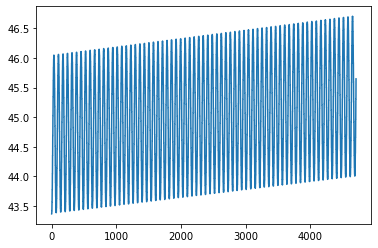

In [158]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))


def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while True:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        #print('x:', x, 'y:', y)
        #print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            #print('sol1:', sol1, 'sol2:', sol2)
            #print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    #print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    #print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx - ty > 0.000001:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if (x - sol1) < 0.000001:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        #print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            #print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        #print('ref:', ref, 'ref shape:', ref.shape)
        if np.linalg.norm(vel_vec) != np.linalg.norm(ref):
            print('unnormalized collision')
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        #print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)
        


#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>(h+s):
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            print('next wall: left')
        else:
            xf = l
            print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            print('bottom bar')
            tf1 = tf - s/v
            tf2 = tf + s/v
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf2 = xf1 + u*(tf2-root)
                if abs(xf2)>l:
                    if abs(xf2%(4*l)) > l:
                        xf2 = xf2%(4*l)
                        if abs(xf2) > (3*l):
                            xf2 = (-np.sign(xf2)*4*l)- xf2
                        elif abs(xf2) > l:
                            xf2 = (np.sign(xf2)*2*l)- xf2
                    
                xf = xf2
                yf = -h
                uf = u
                if abs(xf2)>l:
                    print('out!')
                
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


    


    


In [156]:
from sklearn.preprocessing import normalize
def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    if v<0:
        print('moving the other direction')
    st = 'en'
    vel_vec = np.array([u, v])
    
    if u == 0:
        m = np.inf
    else:
        m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    while True:
        ball_y_right = m*(l-x)+y 
        ball_y_left = m*(-l-x)+y 
        if m == slope:
            x_int = 3
        else:
            x_int = (h-y+(slope*l)+(m*x))/(m-slope)
        print(x_int)
        if ((-l<x_int) and (x_int<l)) and st != "sl" :
            print('slop')
            xf = x_int
            yf = m*(xf-x)+y
            nor_vec = normalize(np.array([1, -(1/slope)]).reshape(2,1))
            st = "sl"
        elif h < ball_y_right < wall_y_right and st != "ve":
            #hit vertical
            print('vert')
            xf = l
            yf = ball_y_right
            nor_vec = normalize(np.array([-1, 0]).reshape(2,1))
            st = "ve"

        else:
            print('exit')
            yf = h
            xf = x + ((h-y)/vel_vec[1])* vel_vec[0]
            t += (h-y)/vel_vec[1]
            if vel_vec[1]>0:
                print('other way:', (h-y)/vel_vec[1])
            return (xf, yf, vel_vec[0], vel_vec[1], t)
                
        t += (xf-x)/vel_vec[0]
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        if np.linalg.norm(vel_vec) != np.linalg.norm(ref):
            print('unnormalized collision')
        x = xf
        y = yf
        vel_vec = np.array(ref)
        print(ref)
        m = float(ref[1]/ref[0])
        
omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
#entered enclosure: x: [-1.30463345] y: 1 u: [-0.70840413] v: [0.70580705]
trapezium_enclosure(x=0, y=h , u=1, v=1, t=0, lam=1, l=l, h=h, s=s, omega=omega)  
                              

3
vert
[[-1.]
 [ 1.]]
1.0
slop
[[ 1.]
 [-1.]]
1.0
vert
[[-1.]
 [-1.]]
3
exit


(array([0.]), 1, array([-1.]), array([-1.]), array([6.]))

next wall: trapezium enclosure
-0.62625
slop
[[ 5.93328772]
 [-2.85676816]]
-0.6262500000000016
vert
[[-5.93328772]
 [-2.85676816]]
-5.503571428571432
exit
next wall: left
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.93848277]
slop
[[ 4.0869114 ]
 [-5.16503165]]
[-0.93848277]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.40290291]
slop
[[ 4.83831686]
 [-4.47499698]]
[-0.40290291]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.87638598]
slop
[[ 4.60410298]
 [-4.72277574]]
[-1.87638598]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.08652147]
slop
unnormalized collision
[[ 4.68950867]
 [-4.64699672]]
[-0.08652147]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97780122]
slop
[[ 4.66857927]
 [-4.67905575]]
[-1.97780122]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04704795]
slop
unnormalized collision
[[ 4.6836723 ]
 [-4.67613185]]
[-0.04704795]
exit
next wall: rig

unnormalized collision
[[ 4.72759787]
 [-4.72319444]]
[-0.02460991]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97667626]
slop
[[ 4.73662156]
 [-4.73211186]]
[-1.97667626]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01716054]
slop
unnormalized collision
[[ 4.74558191]
 [-4.74110385]]
[-0.01716054]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97296766]
slop
unnormalized collision
[[ 4.75437441]
 [-4.74998019]]
[-1.97296766]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00987902]
slop
[[ 4.76302445]
 [-4.75870139]]
[-0.00987902]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96960991]
slop
unnormalized collision
[[ 4.77113669]
 [-4.76708229]]
[-1.96960991]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00313379]
slop
unnormalized collision
[[ 4.77903501]
 [-4.77508748]]
[-0.00313379]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9667

next wall: right
next wall: trapezium enclosure
[-0.02668437]
slop
unnormalized collision
[[ 4.72432389]
 [-4.71997457]]
[-0.02668437]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97739067]
slop
[[ 4.73333314]
 [-4.72883065]]
[-1.97739067]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01925455]
slop
unnormalized collision
[[ 4.7422995 ]
 [-4.73781843]]
[-0.01925455]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97362327]
slop
[[ 4.75119245]
 [-4.74674805]]
[-1.97362327]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01189828]
slop
unnormalized collision
[[ 4.75996209]
 [-4.75557928]]
[-0.01189828]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9701622]
slop
[[ 4.76828416]
 [-4.76412494]]
[-1.9701622]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00498848]
slop
[[ 4.77640921]
 [-4.77234841]]
[-0.00498848]
exit
next wall: right
bottom bar
next wall: trapezium

slop
[[ 4.78106319]
 [-4.77725076]]
[-1.96766569]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00062982]
slop
[[ 4.78844616]
 [-4.78475609]]
[-0.00062982]
vert
[[-4.78844616]
 [-4.78475609]]
[-5188.26802761]
exit
bottom bar
next wall: trapezium enclosure
[-1.96512828]
slop
unnormalized collision
[[ 4.7948007 ]
 [-4.79162448]]
[-1.96512828]
exit
bottom bar
next wall: trapezium enclosure
[2111.05674594]
vert
[[-4.7948007 ]
 [ 4.80388165]]
[0.0047013]
slop
[[ 4.80085658]
 [-4.79782959]]
[0.0047013]
vert
[[-4.80085658]
 [-4.79782959]]
[-6325.17023783]
exit
bottom bar
next wall: trapezium enclosure
[-1.96330297]
slop
unnormalized collision
[[ 4.80561694]
 [-4.80323734]]
[-1.96330297]
exit
bottom bar
next wall: trapezium enclosure
[2889.22146595]
vert
[[-4.80561694]
 [ 4.81225018]]
[0.00874355]
slop
unnormalized collision
[[ 4.81004011]
 [-4.80782903]]
[0.00874355]
vert
[[-4.81004011]
 [-4.80782903]]
[-8659.66439785]
exit
bottom bar
next wall: trapezium enclosure
[-1.9

[[-4.81432179]
 [ 4.81005091]]
[0.0096968]
slop
[[ 4.81147495]
 [-4.81289858]]
[0.0096968]
vert
[[-4.81147495]
 [-4.81289858]]
[13457.36344995]
exit
bottom bar
next wall: trapezium enclosure
[-1.96570095]
slop
unnormalized collision
[[ 4.80708039]
 [-4.80927817]]
[-1.96570095]
exit
bottom bar
next wall: trapezium enclosure
[-2728.05498396]
vert
[[-4.80708039]
 [ 4.80006419]]
[0.0062123]
slop
unnormalized collision
[[ 4.80240406]
 [-4.8047428 ]]
[0.0062123]
vert
[[-4.80240406]
 [-4.8047428 ]]
[8192.16495188]
exit
bottom bar
next wall: trapezium enclosure
[-1.96848938]
slop
[[ 4.79635729]
 [-4.79938163]]
[-1.96848938]
exit
bottom bar
next wall: trapezium enclosure
[-2033.832347]
vert
[[-4.79635729]
 [ 4.78694895]]
[0.00133656]
slop
unnormalized collision
[[ 4.79008711]
 [-4.79322323]]
[0.00133656]
vert
[[-4.79008711]
 [-4.79322323]]
[6109.497041]
exit
bottom bar
next wall: trapezium enclosure
[-1.97182887]
slop
unnormalized collision
[[ 4.78269396]
 [-4.78639197]]
[-1.97182887]
exit
bott

next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97600732]
slop
[[ 4.73993949]
 [-4.73543055]]
[-1.97600732]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01870352]
slop
unnormalized collision
[[ 4.7489048 ]
 [-4.74442426]]
[-0.01870352]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97228084]
slop
unnormalized collision
[[ 4.75773173]
 [-4.7533203 ]]
[-1.97228084]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01140436]
slop
[[ 4.76642225]
 [-4.76207897]]
[-0.01140436]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96889063]
slop
[[ 4.77460382]
 [-4.77051478]]
[-1.96889063]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00461246]
slop
unnormalized collision
[[ 4.78257679]
 [-4.77859196]]
[-0.00461246]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96600327]
slop
unnormalized collision
[[ 4.78969784]
 [-4.78613863]]
[-1.96600327]
exit
bottom bar
n

bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04642337]
slop
[[ 4.67859068]
 [-4.68167965]]
[-0.04642337]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99463884]
slop
[[ 4.67370982]
 [-4.67615088]]
[-1.99463884]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.050627]
slop
[[ 4.66916849]
 [-4.67143971]]
[-0.050627]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99568734]
slop
unnormalized collision
[[ 4.66613698]
 [-4.66765298]]
[-1.99568734]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05330099]
slop
[[ 4.66346884]
 [-4.6648031 ]]
[-0.05330099]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99583815]
slop
unnormalized collision
[[ 4.66244599]
 [-4.66295744]]
[-1.99583815]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05430475]
slop
[[ 4.66179124]
 [-4.66211862]]
[-0.05430475]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1

 [-4.76989159]]
[-0.01033505]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97783833]
slop
[[ 4.75695604]
 [-4.76136275]]
[-1.97783833]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0176088]
slop
[[ 4.74813208]
 [-4.75254612]]
[-0.0176088]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98176141]
slop
[[ 4.73911768]
 [-4.74362703]]
[-1.98176141]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02510165]
slop
[[ 4.73017144]
 [-4.73464668]]
[-0.02510165]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98551838]
slop
unnormalized collision
[[ 4.7214168 ]
 [-4.72579615]]
[-1.98551838]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0324254]
slop
unnormalized collision
[[ 4.71281004]
 [-4.71711539]]
[-0.0324254]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98890869]
slop
[[ 4.70476906]
 [-4.70879127]]
[-1.98890869]
exit
bottom bar
next wall: right

unnormalized collision
[[ 4.70310034]
 [-4.707165  ]]
[-0.03729995]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99064641]
slop
[[ 4.69577711]
 [-4.69944015]]
[-1.99064641]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04349516]
slop
[[ 4.6887168 ]
 [-4.69224828]]
[-0.04349516]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99303072]
slop
unnormalized collision
[[ 4.68277618]
 [-4.68574743]]
[-1.99303072]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04856622]
slop
unnormalized collision
[[ 4.67715032]
 [-4.6799641 ]]
[-0.04856622]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99463164]
slop
unnormalized collision
[[ 4.67290358]
 [-4.67502744]]
[-1.99463164]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05224396]
slop
unnormalized collision
[[ 4.66900709]
 [-4.67095574]]
[-0.05224396]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9953

unnormalized collision
[[ 4.66632701]
 [-4.66579538]]
[-1.99435409]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0542892]
slop
unnormalized collision
[[ 4.66774374]
 [-4.66703543]]
[-0.0542892]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99273868]
slop
[[ 4.67081124]
 [-4.66927774]]
[-1.99273868]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05187856]
slop
[[ 4.67419877]
 [-4.67250531]]
[-0.05187856]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99035883]
slop
unnormalized collision
[[ 4.67910905]
 [-4.67665456]]
[-1.99035883]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04792656]
slop
[[ 4.68428931]
 [-4.6816999 ]]
[-0.04792656]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98734395]
slop
unnormalized collision
[[ 4.69078518]
 [-4.68753837]]
[-1.98734395]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04264619]
slop
[[ 4.69748704]

[-0.0247843]
slop
[[ 4.74299845]
 [-4.73855216]]
[-0.0247843]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97349263]
slop
[[ 4.75200528]
 [-4.747504  ]]
[-1.97349263]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01736304]
slop
[[ 4.7609274 ]
 [-4.75646843]]
[-0.01736304]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9698639]
slop
[[ 4.76958198]
 [-4.76525665]]
[-1.9698639]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0102087]
slop
[[ 4.77807442]
 [-4.77383008]]
[-0.0102087]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96662996]
slop
unnormalized collision
[[ 4.78593729]
 [-4.78200747]]
[-1.96662996]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00368085]
slop
unnormalized collision
[[ 4.79356919]
 [-4.78975475]]
[-0.00368085]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96394913]
slop
[[ 4.80024295]
 [-4.79690722]]
[-1.96394913]


 [-4.8251778 ]]
[-1.96137035]
exit
bottom bar
next wall: trapezium enclosure
[-5800.92787587]
vert
[[-4.82424327]
 [ 4.82093367]]
[0.00880768]
slop
[[ 4.82203712]
 [-4.82314032]]
[0.00880768]
vert
[[-4.82203712]
 [-4.82314032]]
[17410.78362761]
exit
bottom bar
next wall: trapezium enclosure
[-1.9632141]
slop
[[ 4.81824535]
 [-4.82014161]]
[-1.9632141]
exit
bottom bar
next wall: trapezium enclosure
[-3127.33642883]
vert
[[-4.81824535]
 [ 4.81210841]]
[0.00583205]
slop
[[ 4.81415493]
 [-4.81620057]]
[0.00583205]
vert
[[-4.81415493]
 [-4.81620057]]
[9390.00928648]
exit
bottom bar
next wall: trapezium enclosure
[-1.96578234]
slop
unnormalized collision
[[ 4.80863024]
 [-4.81139338]]
[-1.96578234]
exit
bottom bar
next wall: trapezium enclosure
[-2216.29556257]
vert
[[-4.80863024]
 [ 4.79997328]]
[0.00140604]
slop
[[ 4.80286067]
 [-4.80574632]]
[0.00140604]
vert
[[-4.80286067]
 [-4.80574632]]
[6656.88668772]
exit
bottom bar
next wall: trapezium enclosure
[-1.96894995]
slop
[[ 4.7958811 ]
 [-

[[ 4.71888747]
 [-4.72310622]]
[-1.98603103]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03740535]
slop
[[ 4.71064086]
 [-4.71476597]]
[-0.03740535]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98915227]
slop
[[ 4.70314561]
 [-4.70689473]]
[-1.98915227]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04372994]
slop
unnormalized collision
[[ 4.69590449]
 [-4.69952644]]
[-0.04372994]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99164152]
slop
[[ 4.68973803]
 [-4.69282227]]
[-1.99164152]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04897792]
slop
unnormalized collision
[[ 4.68387976]
 [-4.68680981]]
[-0.04897792]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99336531]
slop
unnormalized collision
[[ 4.67936435]
 [-4.6816226 ]]
[-1.99336531]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05287138]
slop
[[ 4.67519521]
 [-4.67728024]]
[-0.

exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99048126]
slop
unnormalized collision
[[ 4.69598468]
 [-4.69935892]]
[-1.99048126]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04724732]
slop
unnormalized collision
[[ 4.68952677]
 [-4.69275684]]
[-0.04724732]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9925277]
slop
[[ 4.68431064]
 [-4.68691943]]
[-1.9925277]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0517157]
slop
[[ 4.6794275 ]
 [-4.68186971]]
[-0.0517157]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99374922]
slop
unnormalized collision
[[ 4.67601414]
 [-4.67772113]]
[-1.99374922]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05469819]
slop
[[ 4.6729613 ]
 [-4.67448797]]
[-0.05469819]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99408259]
slop
[[ 4.67152942]
 [-4.67224541]]
[-1.99408259]
exit
bottom bar
next wall: right
next w

[-0.01015639]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97488213]
slop
unnormalized collision
[[ 4.77085312]
 [-4.77518741]]
[-1.97488213]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01728051]
slop
[[ 4.76214954]
 [-4.76650332]]
[-0.01728051]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97881017]
slop
unnormalized collision
[[ 4.75314718]
 [-4.7576505 ]]
[-1.97881017]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02473246]
slop
unnormalized collision
[[ 4.74418873]
 [-4.74867008]]
[-0.02473246]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98263298]
slop
[[ 4.73531039]
 [-4.73975165]]
[-1.98263298]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03212886]
slop
[[ 4.72655698]
 [-4.73093572]]
[-0.03212886]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98614789]
slop
unnormalized collision
[[ 4.71826056]
 [-4.7224106 ]]
[-1.98614789

slop
[[ 4.82726549]
 [-4.82856018]]
[-1.96098264]
exit
bottom bar
next wall: trapezium enclosure
[-4397.02621735]
vert
[[-4.82726549]
 [ 4.82289328]]
[0.00692621]
slop
unnormalized collision
[[ 4.82435112]
 [-4.82580853]]
[0.00692621]
vert
[[-4.82435112]
 [-4.82580853]]
[13199.07865206]
exit
bottom bar
next wall: trapezium enclosure
[-1.96310124]
slop
[[ 4.81989966]
 [-4.82212591]]
[-1.96310124]
exit
bottom bar
next wall: trapezium enclosure
[-2706.6700635]
vert
[[-4.81989966]
 [ 4.81279927]]
[0.00340385]
slop
unnormalized collision
[[ 4.81516723]
 [-4.81753403]]
[0.00340385]
vert
[[-4.81516723]
 [-4.81753403]]
[8128.01019051]
exit
bottom bar
next wall: trapezium enclosure
[-1.96590188]
slop
[[ 4.80907629]
 [-4.81212273]]
[-1.96590188]
exit
bottom bar
next wall: trapezium enclosure
[-2028.15637539]
vert
[[-4.80907629]
 [ 4.79960327]]
[-0.00149472]
slop
[[ 4.80276302]
 [-4.8059207 ]]
[-0.00149472]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96924721]
slop
unnorma

 [ 4.83220072]]
[0.0090124]
slop
unnormalized collision
[[ 4.83223138]
 [-4.83226203]]
[0.0090124]
vert
[[-4.83223138]
 [-4.83226203]]
[627683.11895169]
exit
bottom bar
next wall: trapezium enclosure
[-1.96004763]
slop
[[ 4.83051375]
 [-4.83137264]]
[-1.96004763]
exit
bottom bar
next wall: trapezium enclosure
[-6231.61305383]
vert
[[-4.83051375]
 [ 4.8274271 ]]
[0.00775631]
slop
[[ 4.8284562 ]
 [-4.82948508]]
[0.00775631]
vert
[[-4.8284562 ]
 [-4.82948508]]
[18702.8391615]
exit
bottom bar
next wall: trapezium enclosure
[-1.9618291]
slop
[[ 4.82480744]
 [-4.82663216]]
[-1.9618291]
exit
bottom bar
next wall: trapezium enclosure
[-3243.49058996]
vert
[[-4.82480744]
 [ 4.81887918]]
[0.00490311]
slop
[[ 4.82085608]
 [-4.82283216]]
[0.00490311]
vert
[[-4.82085608]
 [-4.82283216]]
[9738.4717699]
exit
bottom bar
next wall: trapezium enclosure
[-1.9643419]
slop
unnormalized collision
[[ 4.81545849]
 [-4.81815804]]
[-1.9643419]
exit
bottom bar
next wall: trapezium enclosure
[-2268.42120474]
vert

unnormalized collision
[[ 4.78853064]
 [-4.79237303]]
[-0.00866137]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97286612]
slop
[[ 4.780077  ]
 [-4.78430569]]
[-1.97286612]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01558936]
slop
unnormalized collision
[[ 4.77155713]
 [-4.77581897]]
[-0.01558936]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97678161]
slop
[[ 4.76261628]
 [-4.76708881]]
[-1.97678161]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02296771]
slop
[[ 4.75369169]
 [-4.75815608]]
[-0.02296771]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98066064]
slop
unnormalized collision
[[ 4.74472065]
 [-4.74920829]]
[-1.98066064]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03041881]
slop
unnormalized collision
[[ 4.73584796]
 [-4.74028639]]
[-0.03041881]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98429865]
slop
unnormalized

next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99235122]
slop
unnormalized collision
[[ 4.68336044]
 [-4.68528155]]
[-1.99235122]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05535601]
slop
unnormalized collision
[[ 4.67987513]
 [-4.68161811]]
[-0.05535601]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99289085]
slop
unnormalized collision
[[ 4.67798097]
 [-4.67892815]]
[-1.99289085]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05707619]
slop
[[ 4.67645603]
 [-4.67721856]]
[-0.05707619]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99252888]
slop
[[ 4.67660794]
 [-4.67653198]]
[-1.99252888]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05709779]
slop
[[ 4.67712285]
 [-4.6768654 ]]
[-0.05709779]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99128909]
slop
[[ 4.67931241]
 [-4.67821776]]
[-1.99128909]
exit
bottom bar
next wall: right
next wa

next wall: trapezium enclosure
[-0.01638833]
slop
unnormalized collision
[[ 4.7731469 ]
 [-4.77742235]]
[-0.01638833]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97646896]
slop
unnormalized collision
[[ 4.76419518]
 [-4.76867315]]
[-1.97646896]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02377339]
slop
unnormalized collision
[[ 4.75526324]
 [-4.75973131]]
[-0.02377339]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9803407]
slop
unnormalized collision
[[ 4.74630135]
 [-4.75078441]]
[-1.9803407]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03121442]
slop
[[ 4.7374412 ]
 [-4.74187335]]
[-0.03121442]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98396312]
slop
unnormalized collision
[[ 4.72892948]
 [-4.73318726]]
[-1.98396312]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03832656]
slop
unnormalized collision
[[ 4.72059666]
 [-4.72476492]]
[-0.03832656]
e

slop
[[ 4.79117288]
 [-4.7952185 ]]
[-1.97040424]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01308711]
slop
unnormalized collision
[[ 4.78298217]
 [-4.78707928]]
[-0.01308711]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97426657]
slop
unnormalized collision
[[ 4.77420756]
 [-4.77859688]]
[-1.97426657]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0202997]
slop
[[ 4.76541131]
 [-4.76981147]]
[-0.0202997]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97818604]
slop
unnormalized collision
[[ 4.75639661]
 [-4.7609061 ]]
[-1.97818604]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02775868]
slop
unnormalized collision
[[ 4.74744306]
 [-4.75192195]]
[-0.02775868]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98195749]
slop
[[ 4.73864984]
 [-4.74304849]]
[-1.98195749]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0350805]
slop
[[ 4.72999

[-1.95832929]
exit
bottom bar
next wall: trapezium enclosure
[-10447.87063242]
vert
[[-4.83771916]
 [ 4.83587447]]
[0.00727025]
slop
unnormalized collision
[[ 4.83648944]
 [-4.83710434]]
[0.00727025]
vert
[[-4.83648944]
 [-4.83710434]]
[31351.61189729]
exit
bottom bar
next wall: trapezium enclosure
[-1.9597747]
slop
[[ 4.83363407]
 [-4.83506197]]
[-1.9597747]
exit
bottom bar
next wall: trapezium enclosure
[-4043.52273556]
vert
[[-4.83363407]
 [ 4.82886931]]
[0.00507724]
slop
unnormalized collision
[[ 4.83045809]
 [-4.83204634]]
[0.00507724]
vert
[[-4.83045809]
 [-4.83204634]]
[12138.56820666]
exit
bottom bar
next wall: trapezium enclosure
[-1.9619901]
slop
unnormalized collision
[[ 4.82576822]
 [-4.82811373]]
[-1.9619901]
exit
bottom bar
next wall: trapezium enclosure
[-2585.92717147]
vert
[[-4.82576822]
 [ 4.81832016]]
[0.00136143]
slop
[[ 4.82080412]
 [-4.82328681]]
[0.00136143]
vert
[[-4.82080412]
 [-4.82328681]]
[7765.78151442]
exit
bottom bar
next wall: trapezium enclosure
[-1.964

[[ 4.83746654]
 [-4.83637478]]
[-1.95750462]
exit
bottom bar
next wall: trapezium enclosure
[7064.64150201]
vert
[[-4.83746654]
 [ 4.84019716]]
[0.00723033]
slop
unnormalized collision
[[ 4.83928712]
 [-4.83837692]]
[0.00723033]
vert
[[-4.83928712]
 [-4.83837692]]
[-21185.92450604]
exit
bottom bar
next wall: trapezium enclosure
[-1.95766118]
slop
unnormalized collision
[[ 4.83946903]
 [-4.83937808]]
[-1.95766118]
exit
bottom bar
next wall: trapezium enclosure
[-72222.37738319]
vert
[[-4.83946903]
 [ 4.83920203]]
[0.00753178]
slop
unnormalized collision
[[ 4.83929103]
 [-4.83938003]]
[0.00753178]
vert
[[-4.83929103]
 [-4.83938003]]
[216675.13215073]
exit
bottom bar
next wall: trapezium enclosure
[-1.95867277]
slop
[[ 4.83746161]
 [-4.83837641]]
[-1.95867277]
exit
bottom bar
next wall: trapezium enclosure
[-5926.74249445]
vert
[[-4.83746161]
 [ 4.83420906]]
[0.00618488]
slop
unnormalized collision
[[ 4.83529349]
 [-4.83637767]]
[0.00618488]
vert
[[-4.83529349]
 [-4.83637767]]
[17788.2274

 [-4.81348374]]
[-1.96062344]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00084539]
slop
unnormalized collision
[[ 4.82303053]
 [-4.81989761]]
[-0.00084539]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.95868713]
slop
[[ 4.8280466 ]
 [-4.82553922]]
[-1.95868713]
exit
bottom bar
next wall: trapezium enclosure
[2749.34859615]
vert
[[-4.8280466 ]
 [ 4.83506923]]
[0.00337548]
slop
[[ 4.83272949]
 [-4.83038861]]
[0.00337548]
vert
[[-4.83272949]
 [-4.83038861]]
[-8240.04578844]
exit
bottom bar
next wall: trapezium enclosure
[-1.95753583]
slop
[[ 4.83595132]
 [-4.83434067]]
[-1.95753583]
exit
bottom bar
next wall: trapezium enclosure
[4493.05331436]
vert
[[-4.83595132]
 [ 4.84024718]]
[0.00614767]
slop
[[ 4.83881565]
 [-4.8373837 ]]
[0.00614767]
vert
[[-4.83881565]
 [-4.8373837 ]]
[-13471.15994309]
exit
bottom bar
next wall: trapezium enclosure
[-1.95722787]
slop
[[ 4.84008262]
 [-4.83944917]]
[-1.95722787]
exit
bottom bar
next wall: trapezium enc

unnormalized collision
[[ 4.71782099]
 [-4.71434136]]
[-0.04507316]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97956304]
slop
unnormalized collision
[[ 4.72575858]
 [-4.72179145]]
[-1.97956304]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03860813]
slop
unnormalized collision
[[ 4.73381358]
 [-4.72978779]]
[-0.03860813]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97575497]
slop
unnormalized collision
[[ 4.74251205]
 [-4.73816481]]
[-1.97575497]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03150001]
slop
[[ 4.75124648]
 [-4.74688127]]
[-0.03150001]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97188254]
slop
unnormalized collision
[[ 4.76026115]
 [-4.75575595]]
[-1.97188254]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02411294]
slop
[[ 4.7692289 ]
 [-4.76474713]]
[-0.02411294]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9681

 [-4.7077502 ]]
[-0.0493234]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9895497]
slop
unnormalized collision
[[ 4.69899579]
 [-4.7017139 ]]
[-1.9895497]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05395325]
slop
unnormalized collision
[[ 4.69388956]
 [-4.69644337]]
[-0.05395325]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99088682]
slop
[[ 4.69022147]
 [-4.69205587]]
[-1.99088682]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05713322]
slop
[[ 4.68691184]
 [-4.68856695]]
[-0.05713322]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99134574]
slop
[[ 4.68520129]
 [-4.68605664]]
[-1.99134574]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05869688]
slop
unnormalized collision
[[ 4.68386058]
 [-4.68453098]]
[-0.05869688]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99090553]
slop
[[ 4.68419645]
 [-4.68402852]]
[-1.99090553]
exit
bot

next wall: trapezium enclosure
[-1.98816864]
slop
unnormalized collision
[[ 4.70673478]
 [-4.70989989]]
[-1.98816864]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05169112]
slop
unnormalized collision
[[ 4.70071001]
 [-4.70372336]]
[-0.05169112]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98998266]
slop
unnormalized collision
[[ 4.69599579]
 [-4.69835349]]
[-1.98998266]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05572967]
slop
[[ 4.69162495]
 [-4.69381088]]
[-0.05572967]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99095297]
slop
[[ 4.68876978]
 [-4.69019759]]
[-1.99095297]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05823843]
slop
[[ 4.6862803 ]
 [-4.68752521]]
[-0.05823843]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99103056]
slop
unnormalized collision
[[ 4.68543274]
 [-4.68585654]]
[-1.99103056]
exit
bottom bar
next wall: right
next wall: t

 [-4.75513381]]
[-0.03025556]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97014866]
slop
[[ 4.76857396]
 [-4.76406532]]
[-1.97014866]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02286401]
slop
[[ 4.77752688]
 [-4.77305251]]
[-0.02286401]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9664713]
slop
unnormalized collision
[[ 4.78628532]
 [-4.7819081 ]]
[-1.9664713]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01566626]
slop
[[ 4.79489654]
 [-4.79059286]]
[-0.01566626]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9631517]
slop
unnormalized collision
[[ 4.8029504 ]
 [-4.79892516]]
[-1.9631517]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00902167]
slop
[[ 4.81078623]
 [-4.80686991]]
[-0.00902167]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96035118]
slop
[[ 4.8177315 ]
 [-4.81426012]]
[-1.96035118]
exit
bottom bar
next wall: right

bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00153652]
slop
[[ 4.83017244]
 [-4.82711734]]
[-0.00153652]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.95732453]
slop
[[ 4.83500947]
 [-4.83259156]]
[-1.95732453]
exit
bottom bar
next wall: trapezium enclosure
[2866.04634462]
vert
[[-4.83500947]
 [ 4.84175832]]
[0.00253324]
slop
[[ 4.83950975]
 [-4.83726013]]
[0.00253324]
vert
[[-4.83950975]
 [-4.83726013]]
[-8590.13903385]
exit
bottom bar
next wall: trapezium enclosure
[-1.95625896]
slop
[[ 4.84253357]
 [-4.8410219 ]]
[-1.95625896]
exit
bottom bar
next wall: trapezium enclosure
[4838.59899743]
vert
[[-4.84253357]
 [ 4.84652983]]
[0.00514032]
slop
[[ 4.84519811]
 [-4.84386603]]
[0.00514032]
vert
[[-4.84519811]
 [-4.84386603]]
[-14507.7969923]
exit
bottom bar
next wall: trapezium enclosure
[-1.95603885]
slop
unnormalized collision
[[ 4.84625834]
 [-4.84572825]]
[-1.95603885]
exit
bottom bar
next wall: trapezium enclosure
[18508.23159963]
vert
[[-4.84

[-198179.05748036]
vert
[[-4.84782746]
 [ 4.8477299 ]]
[0.00586913]
slop
[[ 4.84776242]
 [-4.84779494]]
[0.00586913]
vert
[[-4.84776242]
 [-4.84779494]]
[594545.17244853]
exit
bottom bar
next wall: trapezium enclosure
[-1.95690026]
slop
unnormalized collision
[[ 4.84604843]
 [-4.8469055 ]]
[-1.95690026]
exit
bottom bar
next wall: trapezium enclosure
[-6269.51795998]
vert
[[-4.84604843]
 [ 4.84296572]]
[0.00461846]
slop
[[ 4.8439935 ]
 [-4.84502107]]
[0.00461846]
vert
[[-4.8439935 ]
 [-4.84502107]]
[18816.55387994]
exit
bottom bar
next wall: trapezium enclosure
[-1.95867216]
slop
unnormalized collision
[[ 4.84035416]
 [-4.84217418]]
[-1.95867216]
exit
bottom bar
next wall: trapezium enclosure
[-3265.83140357]
vert
[[-4.84035416]
 [ 4.83443821]]
[0.00178185]
slop
[[ 4.836411  ]
 [-4.83838298]]
[0.00178185]
vert
[[-4.836411  ]
 [-4.83838298]]
[9805.4942107]
exit
bottom bar
next wall: trapezium enclosure
[-1.96117261]
slop
unnormalized collision
[[ 4.83102699]
 [-4.83371974]]
[-1.96117261]

[-0.01054869]
slop
[[ 4.80701503]
 [-4.81075473]]
[-0.01054869]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96898061]
slop
unnormalized collision
[[ 4.79870727]
 [-4.80286295]]
[-1.96898061]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01732185]
slop
[[ 4.7903168 ]
 [-4.79451387]]
[-0.01732185]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97287103]
slop
[[ 4.78143677]
 [-4.78587885]]
[-1.97287103]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02461237]
slop
[[ 4.77255599]
 [-4.77699845]]
[-0.02461237]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97676646]
slop
[[ 4.76355421]
 [-4.76805724]]
[-1.97676646]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0320504]
slop
[[ 4.75463412]
 [-4.75909626]]
[-0.0320504]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98046334]
slop
[[ 4.74596988]
 [-4.75030398]]
[-1.98046334]
exit
bottom bar
nex

[[ 4.69735763]
 [-4.69946308]]
[-0.05732531]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98968853]
slop
unnormalized collision
[[ 4.69467509]
 [-4.69601655]]
[-1.98968853]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05968667]
slop
[[ 4.69235959]
 [-4.69351748]]
[-0.05968667]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98968909]
slop
unnormalized collision
[[ 4.69168999]
 [-4.6920248 ]]
[-1.98968909]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.06038556]
slop
[[ 4.69138905]
 [-4.69153952]]
[-0.06038556]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98880102]
slop
unnormalized collision
[[ 4.69276681]
 [-4.69207798]]
[-1.98880102]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05938869]
slop
[[ 4.69449568]
 [-4.69363132]]
[-0.05938869]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98707596]
slop
unnormalized collision
[[ 4.6978487

next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96515924]
slop
[[ 4.79278132]
 [-4.78840422]]
[-1.96515924]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01698354]
slop
unnormalized collision
[[ 4.8013924 ]
 [-4.79708879]]
[-0.01698354]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96184124]
slop
unnormalized collision
[[ 4.80944721]
 [-4.80542149]]
[-1.96184124]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01034955]
slop
unnormalized collision
[[ 4.81728408]
 [-4.81336724]]
[-0.01034955]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.95904073]
slop
[[ 4.82423253]
 [-4.82075955]]
[-1.95904073]
exit


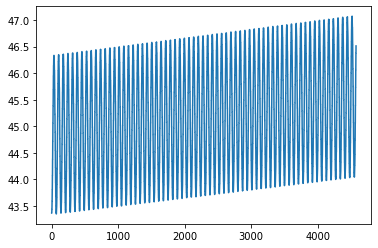

In [159]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y
'''
def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))

'''
def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    if v<0:
        print('moving the other direction')
    st = 'en'
    vel_vec = np.array([u, v])
    
    if u == 0:
        m = np.inf
    else:
        m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    while True:
        ball_y_right = m*(l-x)+y 
        ball_y_left = m*(-l-x)+y 
        if m == slope:
            x_int = 3
        else:
            x_int = (h-y+(slope*l)+(m*x))/(m-slope)
        print(x_int)
        if ((-l<x_int) and (x_int<l)) and st != "sl" :
            print('slop')
            xf = x_int
            yf = m*(xf-x)+y
            nor_vec = normalize(np.array([1, -(1/slope)]).reshape(2,1))
            st = "sl"
        elif h < ball_y_right < wall_y_right and st != "ve":
            #hit vertical
            print('vert')
            xf = l
            yf = ball_y_right
            nor_vec = normalize(np.array([-1, 0]).reshape(2,1))
            st = "ve"

        else:
            print('exit')
            yf = h
            xf = x + ((h-y)/vel_vec[1])* vel_vec[0]
            t += (h-y)/vel_vec[1]
            if vel_vec[1]>0:
                print('other way:', (h-y)/vel_vec[1])
            return (xf, yf, vel_vec[0], vel_vec[1], t)
                
        t += (xf-x)/vel_vec[0]
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        if np.linalg.norm(vel_vec) != np.linalg.norm(ref):
            print('unnormalized collision')
        x = xf
        y = yf
        vel_vec = np.array(ref)
        print(ref)
        m = float(ref[1]/ref[0])
        


#mapping function from one state to the next  
def trapezium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>(h+s):
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            print('next wall: left')
        else:
            xf = l
            print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: trapezium enclosure')
            (xf, yf , uf, vf, tf) = trapezium_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            print('bottom bar')
            tf1 = tf - s/v
            tf2 = tf + s/v
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf2 = xf1 + u*(tf2-root)
                if abs(xf2)>l:
                    if abs(xf2%(4*l)) > l:
                        xf2 = xf2%(4*l)
                        if abs(xf2) > (3*l):
                            xf2 = (-np.sign(xf2)*4*l)- xf2
                        elif abs(xf2) > l:
                            xf2 = (np.sign(xf2)*2*l)- xf2
                    
                xf = xf2
                yf = -h
                uf = u
                if abs(xf2)>l:
                    print('out!')
                
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = trapezium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


    